In [1]:
import pandas as pd
import numpy as np
import re
import uuid
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans

import plotly.graph_objects as go

from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns=None
pd.options.mode.chained_assignment = None

C:\Users\User\AppData\Local\Temp\ipykernel_19124\3040544828.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
stud_feb= pd.read_excel(r'C:\Users\User\studenti_cases\studenti_feb_24.xlsx')

In [3]:
# Добавление uuid
def text_to_uuid(text):
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, text))
stud_feb.insert(0, 'uuid', stud_feb.apply(lambda row: text_to_uuid(' '.join(row['ФИО'])), axis=1))
stud_feb_fio_uuid_full=stud_feb.copy()
stud_feb_fio_uuid=stud_feb.drop_duplicates(subset='uuid')
# удаление лишних столбцов 
stud_feb.drop(columns=['ФИО','№п/п'], inplace=True)
# меняю названия столбцов
stud_feb=stud_feb.rename(columns={"Номер ЛД": "id",'Уровень подготовки':'degree','Специальность/направление':'faculty','Учебный год':'year','Полугодие':'semester','Дисциплина':'subject','Оценка (без пересдач)':'marks','Оценка (успеваемость)':'marks_final','Корпоративный Email':'email','Учебная группа':'group'})
# убираю все нули
# stud_feb = stud_feb.dropna(subset=['marks', 'marks_final'], how='all') 
# убираем будущее
stud_feb['marks'] = stud_feb['marks'].str.strip()
stud_feb['marks_final'] = stud_feb['marks_final'].str.strip()
stud_feb=stud_feb.query('year != "2024 - 2025" and year != "2025 - 2026" and year != "2026 - 2027" and year != "2027 - 2028" and year != "2028 - 2029" and year != "2029 - 2030" ').reset_index(drop=True)

# год и семестр вместе, убираем еще один слой будущего 
stud_feb['date']=stud_feb['year'] + stud_feb['semester']
stud_feb['date'] = stud_feb['date'].str.strip()
stud_feb=stud_feb.query('date != "2023 - 2024II полугодие"')

dict={"2020 - 2021I полугодие": "20_21_semestr1",
    "2020 - 2021II полугодие": "20_21_semestr2",
    "2021 - 2022I полугодие": "21_22_semestr1",
    "2021 - 2022II полугодие": "21_22_semestr2",
    "2022 - 2023I полугодие": "22_23_semestr1",
    "2022 - 2023II полугодие": "22_23_semestr2",
    "2023 - 2024I полугодие": "23_24_semestr1"}
stud_feb['date'].replace(dict,inplace=True)
# датафрейм, в котором в котором пропущенны оба значения в оценках 
stud_null = stud_feb[(stud_feb['marks'].isnull()) & (stud_feb['marks_final'].isnull())]
# выделяем курс студента для каждого наблюдения 
stud_feb['year_group'] = stud_feb['group'].str.extract(r'-(\d{2})-')

stud_feb['year_group'] = stud_feb['year_group'].astype(float)

stud_feb['year_group'] = stud_feb['year_group'].apply(lambda x: 2000 + x)
stud_feb['year_group'].value_counts()
####  выбор нужного курса 
# к нижнему регистру столбец degree
stud_feb['degree'] = stud_feb['degree'].str.lower()

#выбираем только бакалавров
stud_feb = stud_feb[stud_feb['degree'].str.contains('бакалавр')]
# оставили только бакалвров, которые сейчас на 4 курсе 
stud_feb=stud_feb[stud_feb['year_group'] == 2020]
stud_feb.info()

C:\Users\User\AppData\Local\Temp\ipykernel_19124\1530545050.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stud_feb['date'].replace(dict,inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 74416 entries, 0 to 349703
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         74416 non-null  object 
 1   email        74416 non-null  object 
 2   subject      74406 non-null  object 
 3   marks        65134 non-null  object 
 4   marks_final  68350 non-null  object 
 5   semester     74406 non-null  object 
 6   year         74406 non-null  object 
 7   id           74416 non-null  int64  
 8   faculty      74416 non-null  object 
 9   degree       74416 non-null  object 
 10  group        74416 non-null  object 
 11  date         74406 non-null  object 
 12  year_group   74416 non-null  float64
dtypes: float64(1), int64(1), object(11)
memory usage: 7.9+ MB


In [4]:
# выбираем только те оценки где, в столбце marks не нулевое значение
# есть предположение, что оценки в этом столбце из ведомости, которая обязательно должна быть закрыта
# соотсветсвенно пропуск обозначает, что это предмет по выбору, который студенту не нужно сдавать 
indexes_to_drop = stud_feb[stud_feb['marks'].isna()].index
stud_feb = stud_feb.drop(index=indexes_to_drop)
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65134 entries, 0 to 349703
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         65134 non-null  object 
 1   email        65134 non-null  object 
 2   subject      65134 non-null  object 
 3   marks        65134 non-null  object 
 4   marks_final  63955 non-null  object 
 5   semester     65134 non-null  object 
 6   year         65134 non-null  object 
 7   id           65134 non-null  int64  
 8   faculty      65134 non-null  object 
 9   degree       65134 non-null  object 
 10  group        65134 non-null  object 
 11  date         65134 non-null  object 
 12  year_group   65134 non-null  float64
dtypes: float64(1), int64(1), object(11)
memory usage: 7.0+ MB


In [5]:
#### унификация оценок неудовлетворительно 
# заменяю пропущенные значения в столбце marks значением 'неудовлетворительно'
stud_feb['marks'].fillna('неудовлетворительно', inplace=True)
# заполняю соответствующие строки в столбце marks_final значением 'неудовлетворительно'
stud_feb['marks_final'].fillna('неудовлетворительно', inplace=True)
stud_feb['marks_final'] = stud_feb['marks_final'].replace(['Неудовлетворительно', 'не зачтено', 'Не допущен'], 'неудовлетворительно')
stud_feb['marks'] = stud_feb['marks'].replace(['Неудовлетворительно', 'не зачтено', 'Не допущен'], 'неудовлетворительно')
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65134 entries, 0 to 349703
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         65134 non-null  object 
 1   email        65134 non-null  object 
 2   subject      65134 non-null  object 
 3   marks        65134 non-null  object 
 4   marks_final  65134 non-null  object 
 5   semester     65134 non-null  object 
 6   year         65134 non-null  object 
 7   id           65134 non-null  int64  
 8   faculty      65134 non-null  object 
 9   degree       65134 non-null  object 
 10  group        65134 non-null  object 
 11  date         65134 non-null  object 
 12  year_group   65134 non-null  float64
dtypes: float64(1), int64(1), object(11)
memory usage: 7.0+ MB


C:\Users\User\AppData\Local\Temp\ipykernel_19124\512558943.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stud_feb['marks'].fillna('неудовлетворительно', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_19124\512558943.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

#### разоварачиваю все оценки для каждого студента в один ряд 

In [6]:
# смотрю динамику пересдач 
stud_feb.head()

,uuid,email,subject,marks,marks_final,semester,year,id,faculty,degree,group,date,year_group
0,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Автоматизация технологических процессов,Хорошо,Хорошо,II полугодие,2022 - 2023,2010218,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,22_23_semestr2,2020.0
1,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Алгоритмы дискретной математики,Хорошо,Хорошо,II полугодие,2021 - 2022,2010218,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
2,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Базы данных,Хорошо,Хорошо,I полугодие,2021 - 2022,2010218,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr1,2020.0
3,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Безопасность жизнедеятельности,неудовлетворительно,зачтено,II полугодие,2021 - 2022,2010218,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
4,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Инженерная компьютерная графика,Хорошо,Хорошо,I полугодие,2020 - 2021,2010218,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,20_21_semestr1,2020.0


In [7]:
pivot_table = pd.pivot_table(stud_feb, index='uuid', columns='date', values='marks', aggfunc=lambda x: ', '.join(x)).reset_index()

In [8]:
# Преобразуем ячейки в списки
for column in pivot_table.columns[1:]:
    pivot_table[column] = pivot_table[column].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

In [9]:
# Создаем DataFrame для каждой оценки и объединяем их
dfs = []
for column in pivot_table.columns[1:]:
    for idx, grades in enumerate(pivot_table[column]):
        expanded_df = pd.DataFrame({
            'uuid': [pivot_table.at[idx, 'uuid']] * len(grades),
            'date': [column] * len(grades),
            'grade': grades
        })
        dfs.append(expanded_df)

result_df = pd.concat(dfs, ignore_index=True)

In [10]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65134 entries, 0 to 65133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uuid    65134 non-null  object
 1   date    65134 non-null  object
 2   grade   65134 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


In [11]:
# считаю количество двоек для каждого студента 
bad_marks_count = result_df[result_df['grade'] == 'неудовлетворительно'].groupby('uuid').size()

result_df['bad_marks'] = result_df['uuid'].map(bad_marks_count)

In [12]:
pivot_table_final= pd.pivot_table(stud_feb, index='uuid', columns='date', values='marks_final', aggfunc=lambda x: ', '.join(x)).reset_index()
# Преобразуем ячейки в списки
for column in pivot_table_final.columns[1:]:
    pivot_table_final[column] = pivot_table_final[column].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
# Создаем DataFrame для каждой оценки и объединяем их
dfsf = []
for column in pivot_table_final.columns[1:]:
    for idx, grades in enumerate(pivot_table_final[column]):
        expanded_dff = pd.DataFrame({
            'uuid': [pivot_table_final.at[idx, 'uuid']] * len(grades),
            'date': [column] * len(grades),
            'grade': grades
        })
        dfsf.append(expanded_dff)

result_dff = pd.concat(dfsf, ignore_index=True)

# считаю количество двоек для каждого студента 
final_marks_count = result_dff[result_dff['grade'] == 'неудовлетворительно'].groupby('uuid').size()

result_dff['bad_marks_final'] = result_dff['uuid'].map(final_marks_count)

In [13]:
result_dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65134 entries, 0 to 65133
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uuid             65134 non-null  object 
 1   date             65134 non-null  object 
 2   grade            65134 non-null  object 
 3   bad_marks_final  38465 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [14]:
result_dff.head(15)

,uuid,date,grade,bad_marks_final
0,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,Удовлетворительно,7.0
1,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,Хорошо,7.0
2,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,зачтено,7.0
3,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,зачтено,7.0
4,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,зачтено,7.0
5,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,зачтено,7.0
6,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,Удовлетворительно,7.0
7,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,Хорошо,7.0
8,00c4a339-6177-522d-8638-ce53266ae980,20_21_semestr1,Хорошо,NaN
9,00c4a339-6177-522d-8638-ce53266ae980,20_21_semestr1,Отлично,NaN


In [15]:
result_df_full=result_df.fillna(0)
result_dff_full=result_dff.fillna(0)

result_df_full=result_df_full.drop_duplicates(subset='uuid')
result_dff_full=result_dff_full.drop_duplicates(subset='uuid')

In [16]:
result_df_full.head()

,uuid,date,grade,bad_marks
0,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,неудовлетворительно,18.0
8,00c4a339-6177-522d-8638-ce53266ae980,20_21_semestr1,Хорошо,3.0
14,0118adcd-86a0-5556-aea3-19a1df4af3a0,20_21_semestr1,Хорошо,16.0
20,01699bac-b70b-5746-a02e-79ed75425f93,20_21_semestr1,Неявка,5.0
25,01ee572a-44d0-53d9-a62e-c7ce700a7172,20_21_semestr1,неудовлетворительно,10.0


In [17]:
result_dff_full.head()

,uuid,date,grade,bad_marks_final
0,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,Удовлетворительно,7.0
8,00c4a339-6177-522d-8638-ce53266ae980,20_21_semestr1,Хорошо,0.0
14,0118adcd-86a0-5556-aea3-19a1df4af3a0,20_21_semestr1,Хорошо,12.0
20,01699bac-b70b-5746-a02e-79ed75425f93,20_21_semestr1,Удовлетворительно,0.0
25,01ee572a-44d0-53d9-a62e-c7ce700a7172,20_21_semestr1,Удовлетворительно,6.0


In [18]:
# объединяю bad и bad_final 

In [19]:
nice_cases=pd.merge(result_df_full[['uuid','bad_marks']],result_dff_full[['uuid','bad_marks_final']],how='inner',on='uuid')

In [20]:
nice_cases['nice_cases'] = nice_cases['bad_marks'] - nice_cases['bad_marks_final']

In [21]:
nice_cases['failds_corrected_percent']=round(nice_cases['nice_cases']/nice_cases['bad_marks']*100,2)
nice_cases.head()

,uuid,bad_marks,bad_marks_final,nice_cases,failds_corrected_percent
0,00bcd658-be72-55ce-a55d-922033d24e8d,18.0,7.0,11.0,61.11
1,00c4a339-6177-522d-8638-ce53266ae980,3.0,0.0,3.0,100.00
2,0118adcd-86a0-5556-aea3-19a1df4af3a0,16.0,12.0,4.0,25.00
3,01699bac-b70b-5746-a02e-79ed75425f93,5.0,0.0,5.0,100.00
4,01ee572a-44d0-53d9-a62e-c7ce700a7172,10.0,6.0,4.0,40.00


In [22]:
count_nice=nice_cases.query('nice_cases > 0')
count_nice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 823 entries, 0 to 1304
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   uuid                      823 non-null    object 
 1   bad_marks                 823 non-null    float64
 2   bad_marks_final           823 non-null    float64
 3   nice_cases                823 non-null    float64
 4   failds_corrected_percent  823 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.6+ KB


In [23]:
# посмотреть группу тех,кто испрвляет больше n % двоек 
nice_cases.describe()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,bad_marks,bad_marks_final,nice_cases,failds_corrected_percent
count,1371.000000,1371.000000,1371.000000,1021.00
mean,4.854121,2.185996,2.668125,-inf
std,4.971805,3.237956,3.655213,NaN
min,0.000000,0.000000,-12.000000,-inf
25%,0.000000,0.000000,0.000000,28.57
50%,3.000000,1.000000,1.000000,66.67
75%,8.000000,3.000000,5.000000,85.71
max,25.000000,28.000000,18.000000,100.00


### общая статистика по студентам бакалврам, обучающимся сейчас на 4 курсе 

In [24]:
# всего студентов в анализе 
print('всего студентов', len(stud_feb['uuid'].unique()))
# все двоечники
print('все двоечники',nice_cases.query('bad_marks != 0').shape[0])
# не двоечники
print('не двоечники',nice_cases.query('bad_marks == 0').shape[0])
# общее количество двоек
print('общее количество двоек',nice_cases['bad_marks'].sum())
# общее количество неисправленных  двоек
print('общее количество неисправленных  двоек',nice_cases['bad_marks_final'].sum())
# процент неисправленных двоек от всех двоек 
print('процент неисправленных двоек от всех двоек ',round(nice_cases['bad_marks_final'].sum()/nice_cases['bad_marks'].sum()*100,2))

# процент исправленных двоек от всех двоек 
print('процент исправленных двоек от всех двоек ',round(nice_cases['nice_cases'].sum()/nice_cases['bad_marks'].sum()*100,2))
# количество двоечников, которые имеют хоть одну неисправленную двойку
print('количество двоечников, которые имеют хоть одну неисправленную двойку',len(nice_cases[nice_cases['bad_marks_final']>0]))

# общее количество неисправленных двоек 
print('общее количество неисправленных двоек ',nice_cases['bad_marks_final'].sum())
# количество двоечников, которые имеют хоть одну исправленную двойку
print('количество двоечников, которые имеют хоть одну исправленную двойку',len(nice_cases[nice_cases['nice_cases']>0]))

# общее количество исправленных двоек 
print('общее количество исправленных двоек ',nice_cases['nice_cases'].sum())

всего студентов 1371
все двоечники 1019
не двоечники 352
общее количество двоек 6655.0
общее количество неисправленных  двоек 2997.0
процент неисправленных двоек от всех двоек  45.03
процент исправленных двоек от всех двоек  54.97
количество двоечников, которые имеют хоть одну неисправленную двойку 801
общее количество неисправленных двоек  2997.0
количество двоечников, которые имеют хоть одну исправленную двойку 823
общее количество исправленных двоек  3658.0


In [25]:
nice_cases_fig= nice_cases[nice_cases['nice_cases'] > 0]

In [26]:
nice_cases_fig.head()

,uuid,bad_marks,bad_marks_final,nice_cases,failds_corrected_percent
0,00bcd658-be72-55ce-a55d-922033d24e8d,18.0,7.0,11.0,61.11
1,00c4a339-6177-522d-8638-ce53266ae980,3.0,0.0,3.0,100.00
2,0118adcd-86a0-5556-aea3-19a1df4af3a0,16.0,12.0,4.0,25.00
3,01699bac-b70b-5746-a02e-79ed75425f93,5.0,0.0,5.0,100.00
4,01ee572a-44d0-53d9-a62e-c7ce700a7172,10.0,6.0,4.0,40.00


In [27]:
nice_cases_fig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 823 entries, 0 to 1304
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   uuid                      823 non-null    object 
 1   bad_marks                 823 non-null    float64
 2   bad_marks_final           823 non-null    float64
 3   nice_cases                823 non-null    float64
 4   failds_corrected_percent  823 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.6+ KB


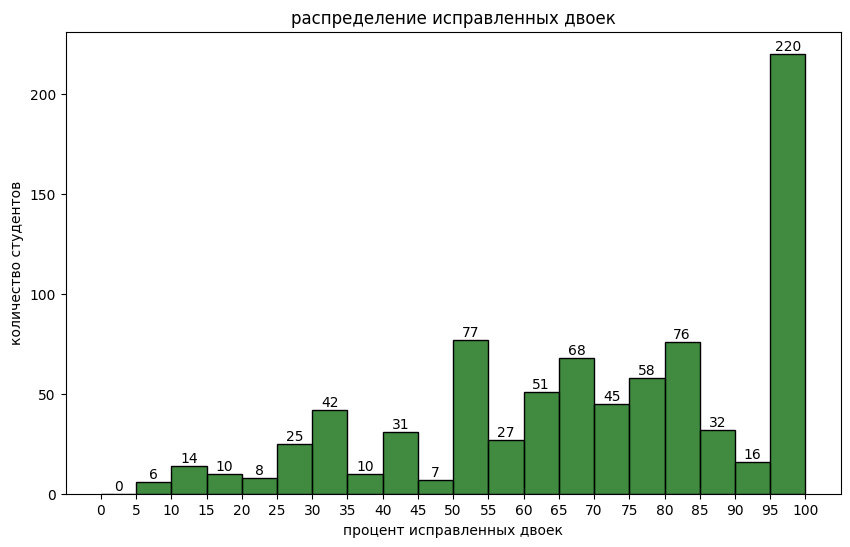

In [28]:
# по оси Y количество студентов, по оси X процент исправленных двоек за все время обучения 
# над каждым столбцом указано количество студентов 

# шаги на оси ox
x_ticks = np.arange(0, 101, 5)

# распределение процента исправленных двоек 
plt.figure(figsize=(10, 6))
histogram=sns.histplot(nice_cases_fig['failds_corrected_percent'], bins=range(0, 101, 5), kde=False, color='darkgreen')
plt.xticks(x_ticks)
plt.title('распределение исправленных двоек')
plt.xlabel('процент исправленных двоек')
plt.ylabel('количество студентов')

# количество наблюдений в каждой группе
for p in histogram.patches:
    histogram.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_19124\2792665304.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_bad_marks = nice_cases_fig.groupby(pd.cut(nice_cases_fig['failds_corrected_percent'], bins=np.arange(0, 105, 5)))['bad_marks'].median()


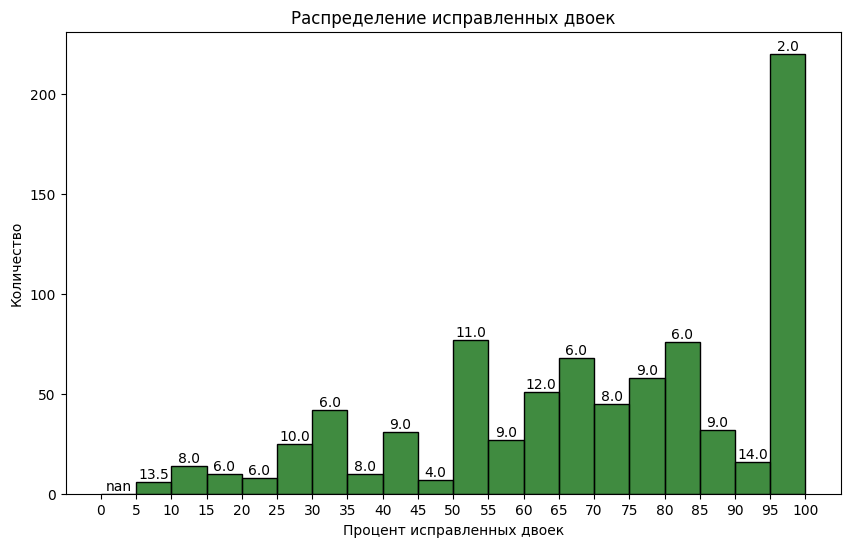

In [29]:
# в этом анализе бакалавры, которые сейчас обучаются на 4 курсе
# по оси Y количество студентов, по оси X процент исправленных двоек за все время обучения 
# над каждым столбцом указано значение медианы двоек(без учета пересдач) у студентов, находящихся в этом столбце 

# Группировка данных по столбцу 'failds_corrected_percent' и расчет медианы 'bad_marks' в каждой группе
median_bad_marks = nice_cases_fig.groupby(pd.cut(nice_cases_fig['failds_corrected_percent'], bins=np.arange(0, 105, 5)))['bad_marks'].median()

# Шаги на оси ox
x_ticks = np.arange(0, 101, 5)

# Распределение процента исправленных двоек 
plt.figure(figsize=(10, 6))
histogram = sns.histplot(nice_cases_fig['failds_corrected_percent'], bins=range(0, 101, 5), kde=False, color='darkgreen')
plt.xticks(x_ticks)
plt.title('Распределение исправленных двоек')
plt.xlabel('Процент исправленных двоек')
plt.ylabel('Количество')

# Количество наблюдений в каждой группе
for i, p in enumerate(histogram.patches):
    median_value = median_bad_marks.iloc[i]
    histogram.annotate(f'{median_value}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_19124\737071794.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_bad_marks = round(nice_cases_fig.groupby(pd.cut(nice_cases_fig['failds_corrected_percent'], bins=np.arange(0, 105, 5)))['bad_marks'].mean(),2)


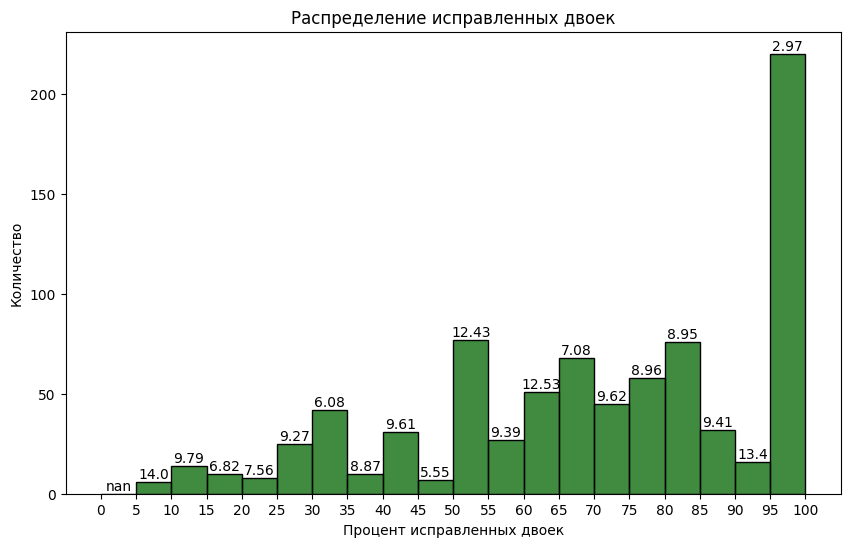

In [30]:
# в этом анализе бакалавры, которые сейчас обучаются на 4 курсе
# по оси Y количество студентов, по оси X процент исправленных двоек за все время обучения 
# над каждым столбцом указано среднее значение двоек(без учета пересдач) у студентов, находящихся в этом столбце 

# Группировка данных по столбцу 'failds_corrected_percent' и расчет медианы 'bad_marks' в каждой группе
median_bad_marks = round(nice_cases_fig.groupby(pd.cut(nice_cases_fig['failds_corrected_percent'], bins=np.arange(0, 105, 5)))['bad_marks'].mean(),2)

# Шаги на оси ox
x_ticks = np.arange(0, 101, 5)

# Распределение процента исправленных двоек 
plt.figure(figsize=(10, 6))
histogram = sns.histplot(nice_cases_fig['failds_corrected_percent'], bins=range(0, 101, 5), kde=False, color='darkgreen')
plt.xticks(x_ticks)
plt.title('Распределение исправленных двоек')
plt.xlabel('Процент исправленных двоек')
plt.ylabel('Количество')

# Количество наблюдений в каждой группе
for i, p in enumerate(histogram.patches):
    median_value = median_bad_marks.iloc[i]
    histogram.annotate(f'{median_value}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()